In [3]:
import numpy as np
import random
import pygame
import os
import sys
import imageio

pygame 2.6.1 (SDL 2.28.4, Python 3.12.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game

: 

In [ ]:
class SpaceShipEnv():
    def __init__(self):
        pygame.init()
        pygame.font.init()

        # 延後畫面初始化，等 render() 時才設置
        self.screen = None
        self.clock = pygame.time.Clock()
        self.fps = FPS

        self.game = Game()

        self.action_space = [0, 1, 2, 3]
        self.observation = self.game.state

    def step(self, action):
        self.game.update(action)
        self.game.draw()

        state = self.game.state
        reward = self.game.score
        done = not self.game.running or self.game.score >= 10000
        info = {}

        return state, reward, done, info

    def reset(self):
        self.game = Game()
        return self.game.state

    def render(self):
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")

        self.game.draw(self.screen)
        pygame.display.update()
        self.clock.tick(self.fps)

    def close(self):
        pygame.quit()


In [ ]:
env = SpaceShipEnv()

for i in range(5):
    state = env.reset()
    done = False
    while not done:
        # env.render()
        action = random.choice(env.action_space)  # 隨機動作
        state, reward, done, info = env.step(action)
        
    
    print(reward)
    # print(state.shape)

env.close()


331
594
144
526
639


In [ ]:
env = SpaceShipEnv()

state = env.reset()
done = False
while not done:
    env.render()
    action = random.choice(env.action_space)  # 隨機動作
    state, reward, done, info = env.step(action)
     
print(reward)
print(state.shape)
    
env.close()

In [ ]:
def record_episode_as_video(env, video_path="gameplay.mp4"):
    frames = []

    state = env.reset()
    done = False

    while not done:
        env.render()
        action = random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        
        # 把畫面抓下來（RGB）
        surface = pygame.display.get_surface()
        frame = pygame.surfarray.array3d(surface)  # shape: (W, H, 3)
        frame = np.transpose(frame, (1, 0, 2))     # pygame 是 x,y → imageio 是 y,x
        frames.append(frame)


    # 儲存成影片
    imageio.mimsave(video_path, frames, fps=60, quality=9)
    print(f"Saved gameplay video to: {video_path}")



In [ ]:
# env = SpaceShipEnv()
# record_episode_as_video(env, "space_ship_run.mp4")
# env.close()


## DQN model

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import cv2
import matplotlib.pyplot as plt

In [ ]:
def preprocess(image):
    # Pygame: (width, height, 3) → OpenCV: (height, width, 3)
    image = np.transpose(image, (1, 0, 2))

    # RGB → 灰階
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize
    image = cv2.resize(image, (84, 84))

    # Normalize 並加入 channel 維度，得到 (1, 84, 84)
    return np.expand_dims(image, axis=0) / 255.0


In [ ]:
# DQN 結構 (灰階單通道)
class DQN(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# 經驗回放
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return (torch.FloatTensor(s), torch.LongTensor(a), torch.FloatTensor(r),
                torch.FloatTensor(s_), torch.FloatTensor(d))

    def __len__(self):
        return len(self.buffer)

In [ ]:
# 超參數
EPISODES = 500
BATCH_SIZE = 256
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.990
LR = 1e-4
TARGET_UPDATE = 5

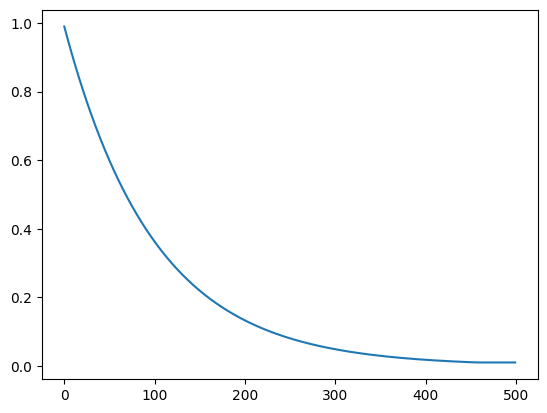

In [ ]:
epsilon_list=[]
epsilon=EPSILON_START
for i in range(500):
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [ ]:
# 初始化
env = SpaceShipEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
action_dim = len(env.action_space)
policy_net = DQN(action_dim).to(device)
target_net = DQN(action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
buffer = ReplayBuffer()

In [ ]:
print(device)

cuda


In [ ]:
# 主訓練迴圈
epsilon = EPSILON_START
reward_history = []
best_reward = -float("inf")  # 初始最佳 reward

for episode in range(EPISODES):
    state = preprocess(env.reset())
    reward = 0
    done = False

    while not done:
        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(env.action_space)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = torch.argmax(q_values).item()

        next_state_raw, reward, done, _ = env.step(action)
        next_state = preprocess(next_state_raw)
        buffer.push(state, action, reward, next_state, done)
        state = next_state

        # 訓練網路
        if len(buffer) >= BATCH_SIZE:
            s, a, r, s_, d = buffer.sample(BATCH_SIZE)
            s = s.to(device)
            a = a.unsqueeze(1).to(device)
            r = r.unsqueeze(1).to(device)
            s_ = s_.to(device)
            d = d.unsqueeze(1).to(device)

            q_values = policy_net(s).gather(1, a)
            with torch.no_grad():
                max_q = target_net(s_).max(1, keepdim=True)[0]
                target = r + GAMMA * max_q * (1 - d)
            loss = F.mse_loss(q_values, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 更新 target 網路
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 10 == 0:
        if reward > best_reward:
            best_reward = reward
            torch.save(policy_net.state_dict(), "best_dqn_space_ship.pth")
            print(f"✔ Episode {episode} save model Total Reward = {reward}")


    reward_history.append(reward)
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    print(f"Episode {episode}, Reward: {reward}, Epsilon: {epsilon:.3f}")

env.close()


✔ Episode 0 save model Total Reward = 45
Episode 0, Reward: 45, Epsilon: 0.990
Episode 1, Reward: 367, Epsilon: 0.980
Episode 2, Reward: 142, Epsilon: 0.970
Episode 3, Reward: 241, Epsilon: 0.961
Episode 4, Reward: 203, Epsilon: 0.951
Episode 5, Reward: 100, Epsilon: 0.941
Episode 6, Reward: 312, Epsilon: 0.932
Episode 7, Reward: 404, Epsilon: 0.923
Episode 8, Reward: 104, Epsilon: 0.914
Episode 9, Reward: 446, Epsilon: 0.904
✔ Episode 10 save model Total Reward = 430
Episode 10, Reward: 430, Epsilon: 0.895
Episode 11, Reward: 112, Epsilon: 0.886
Episode 12, Reward: 182, Epsilon: 0.878
Episode 13, Reward: 194, Epsilon: 0.869
Episode 14, Reward: 133, Epsilon: 0.860
Episode 15, Reward: 339, Epsilon: 0.851
Episode 16, Reward: 180, Epsilon: 0.843
Episode 17, Reward: 375, Epsilon: 0.835
Episode 18, Reward: 712, Epsilon: 0.826
Episode 19, Reward: 565, Epsilon: 0.818
✔ Episode 20 save model Total Reward = 466
Episode 20, Reward: 466, Epsilon: 0.810
Episode 21, Reward: 397, Epsilon: 0.802
Epis

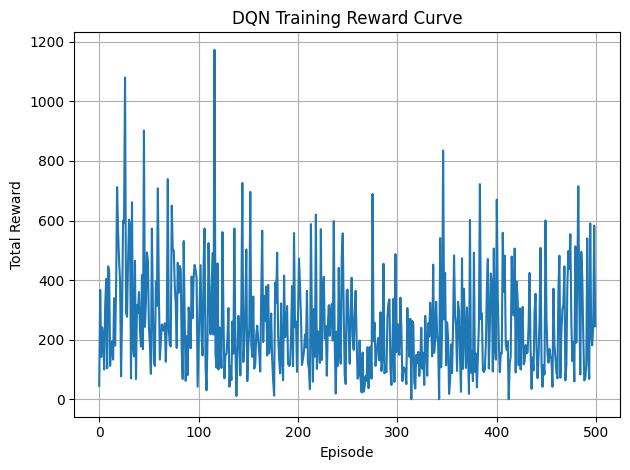

In [ ]:
# 畫出 reward 曲線圖
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Reward Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def play_with_trained_model():
    env = SpaceShipEnv()
    policy_net = DQN(action_dim)
    policy_net.load_state_dict(torch.load("best_dqn_space_ship.pth", map_location=torch.device('cuda')))
    policy_net.eval()

    state = preprocess(env.reset())
    done = False
    reward = 0

    while not done:
        env.render()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action = torch.argmax(q_values).item()

        next_state_raw, reward, done, _ = env.step(action)
        state = preprocess(next_state_raw)

    env.close()
    print(f"reward: {reward}")


In [ ]:
# 呼叫測試函數
play_with_trained_model()